# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
# Your code here
boston = pd.read_csv('../data/boston_data.csv')

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

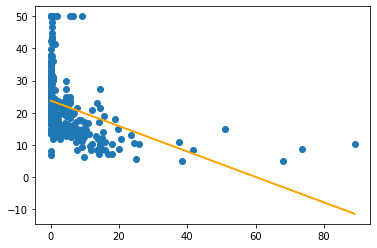

In [33]:
# Your plots here
boston.head()
#boston.dtypes

#sns.boxplot(boston['crim'])
#sns.boxplot(boston['age'])
#sns.boxplot(boston['tax'])

import statsmodels.api as sm
X = boston[['crim','age','tax']]
y = boston['medv']

model = sm.OLS(y,X).fit()

model.summary()

from scipy import stats

X = boston['crim']
results = stats.linregress(X,y)
regression_line = results.slope*X + results.intercept
plt.plot(X, regression_line, c = 'orange')
plt.scatter(X,y)
plt.show()


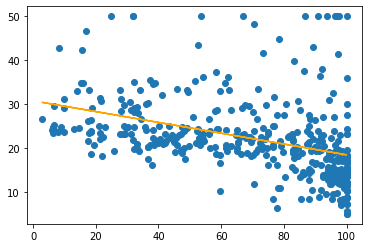

In [34]:
X = boston['age']
results = stats.linregress(X,y)
regression_line = results.slope*X + results.intercept
plt.plot(X, regression_line, c = 'orange')
plt.scatter(X,y)
plt.show()

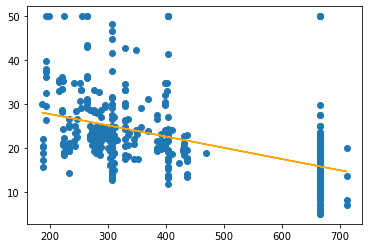

In [35]:
X = boston['tax']
results = stats.linregress(X,y)
regression_line = results.slope*X + results.intercept
plt.plot(X, regression_line, c = 'orange')
plt.scatter(X,y)
plt.show()

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [36]:
# Your response here
#although there is some indication of linear relationship in all of them, crime and tax arent as related as we might think

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

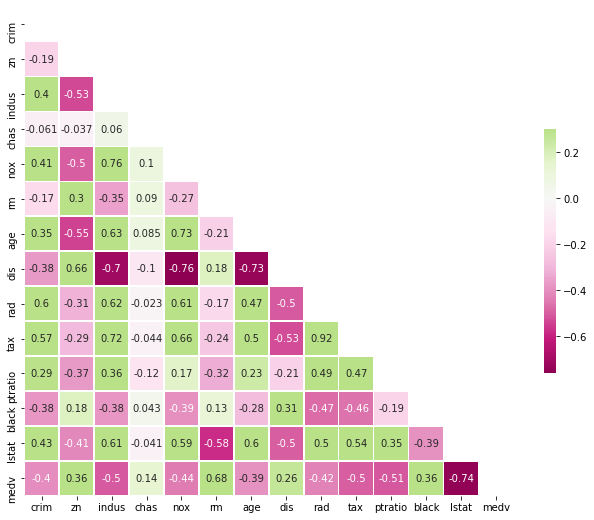

In [42]:
# Your response here
boston_corr = boston.corr()

mask = np.triu(np.ones_like(boston_corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(boston_corr, mask=mask,annot=True, cmap="PiYG", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#yes: lstat, rm, indus, tax, ptratio, rad, nox, crim seem to have the highest correlations

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [41]:
# Your code here
boston['medv'].describe()

count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [43]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [45]:
# Your code here
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(boston.drop(columns = ['medv']), boston['medv'], random_state = 0, test_size = 0.2, shuffle= True)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [52]:
# Five separate RFR here with the given max depths
from sklearn.ensemble import RandomForestRegressor

forest2 = RandomForestRegressor(n_estimators=10,
                               max_depth=2,
                               random_state=1)

forest4 = RandomForestRegressor(n_estimators=10,
                               max_depth=4,
                               random_state=1)

forest6 = RandomForestRegressor(n_estimators=10,
                               max_depth=6,
                               random_state=1)

forest8 = RandomForestRegressor(n_estimators=10,
                               max_depth=8,
                               random_state=1)
forest10 = RandomForestRegressor(n_estimators=10,
                               max_depth=10,
                               random_state=1)
forest2.fit(x_train, y_train)
forest4.fit(x_train, y_train)
forest6.fit(x_train, y_train)
forest8.fit(x_train, y_train)
forest10.fit(x_train, y_train)



RandomForestRegressor(max_depth=10, n_estimators=10, random_state=1)

Now, plot the score for each tree on the training set and on the testing set.

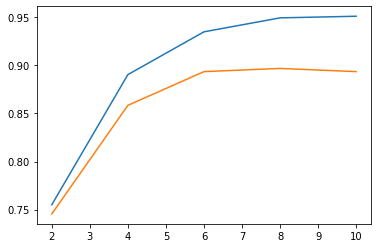

In [61]:
# Produce a plot with the score for the testing and training for the different max depths

x = np.array([2,4,6,8,10])
y1 = np.array([forest2.score(x_train,y_train),forest4.score(x_train,y_train),forest6.score(x_train,y_train),forest8.score(x_train,y_train), forest10.score(x_train,y_train)])
y2 = np.array([forest2.score(x_test,y_test),forest4.score(x_test,y_test),forest6.score(x_test,y_test),forest8.score(x_test,y_test), forest10.score(x_test,y_test)])

plt.plot(x,y1)
plt.plot(x,y2)

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [62]:
# Your response here
#the test scores (orange) start to level off after around 6


### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [64]:
# Your response here
#A model trained on a depth of 10 will have a high variance, but low bias because it will be overitting to the train data
#A model trained on a depth of 1 will have a low variance, but the bias may be high, as it may be oversimplifying the model

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [67]:
# Your response here
#It is probaby best to stop at 6, as that has the minimum difference between test and train scores with a high score overall
print(forest6.score(x_train,y_train),
forest6.score(x_test,y_test))
# it is not overfitting here, but still has a test accuracy of just under 90%

0.9349324812662582 0.8935185146327295


### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [68]:
# Your response here
#i do not think it should be used since a 89% accuracy is still not ideal,
#the data is outdated, we would need more features to fully describe the house value,
#and the sample selected is not random, it is in a city with a much higher quality of life than average